**ASSIGNMENT 1 - EMPIRICAL STUDY OF KNAPSACK PROBLEM**

**1. Group Description**

Group Number: 10

Member Name 1: Xiaoxuan Wang

Member Student Number 1: 300133594

Member Name 2: Victor Li

Member Student Number 2: 300146133

**2. Knapsack Problem**

This assignment asked to solve the 0-1 knapsack problem. It is a classic optimization problem where you are given a set of items, each with a specific weight and a value. The goal is to determine the maximum value that can be obtained by selecting a subset of the items in such a way that the sum of the selected items' weights does not exceed a given capacity.

The problem is NP-hard, meaning that as the number of items increases, the number of possible combinations grows exponentially, making it computationally infeasible to accurately find the best solution for large instances. Therefore, algorithms, such as greedy algorithms, simulated annealing and genetic algorithms, are used to *approximate* solutions to this problem efficiently, which is the main objective of this assignment.

**3. Dataset**

The dataset is coming from [Kaggle](https://www.kaggle.com/). It can be retrieved by following [this link](https://www.kaggle.com/datasets/warcoder/knapsack-problem?resource=download). Each entry of the dataset includes the following key-value pairs:

1. Weights: A list of 5 numerical values representing the weights of 5 different items.
2. Prices: A list of 5 numerical values representing the corresponding prices or values of the items.
3. Capacity: A numerical value indicating the maximum weight the knapsack can hold.
4. Best Picks: A list of 5 binary values (0 or 1) indicating whether the corresponding item is included in the optimal solution (1 for included, 0 for excluded).
5. Best Price: A numerical value representing the maximum value achievable in the knapsack given the weights, prices, and capacity constraints.

**Import important libraries**

In [2]:
import pandas as pd
import itertools
import numpy as np

**Read Dataset**

As outlined in the project description, it should be possible for the correctors to execute your notebook without requiring any downloads.

To facilitate access to the dataset without the need for downloads, you can upload it to a public GitHub repository and provide a link to the raw version of the dataset.

The link to the raw version is as follows:
*https://raw.githubusercontent.com/GITHUB_USERNAME/REPOSITORY_NAME/main/DATASETNAME.csv*

For example:

https://raw.githubusercontent.com/baharin/KnapsackProblem/main/knapsack_5_items.csv

Now provide the link to YOUR dataset and read the dataset using pandas:

In [3]:
url = "https://raw.githubusercontent.com/uOttawa-Collabs/CSI4106-Fall-2023/master/Assignment%201/knapsack_5_items.csv"
dataset = pd.read_csv(url)

Let's see what are the columns of the dataset? :

In [4]:
dataset.columns

Index(['Weights', 'Prices', 'Capacity', 'Best picks', 'Best price'], dtype='object')

As we expected, we have columns for weights, costs, capacity, best picks and best price for all the instances.

Now let's see the first 10 entries (rows):

In [5]:
dataset.head(10)

,Weights,Prices,Capacity,Best picks,Best price
0,[46 40 42 38 10],[12 19 19 15 8],40,[0. 1. 0. 0. 0.],19.0
1,[11 31 4 6 7],[ 2 8 18 16 3],64,[1. 1. 1. 1. 1.],47.0
2,[32 49 27 37 24],[19 16 16 4 1],87,[1. 0. 1. 0. 1.],36.0
3,[20 35 22 23 16],[19 17 19 9 1],21,[1. 0. 0. 0. 0.],19.0
4,[ 7 12 19 13 20],[10 11 18 15 5],50,[0. 1. 1. 1. 0.],44.0
5,[27 10 25 25 7],[13 19 7 16 3],66,[1. 1. 0. 1. 0.],48.0
6,[21 2 33 45 26],[ 1 14 10 6 13],80,[0. 1. 1. 0. 1.],37.0
7,[37 27 39 14 25],[18 7 15 4 13],35,[0. 0. 0. 0. 1.],13.0
8,[ 1 48 4 23 39],[ 9 4 10 16 12],51,[1. 0. 1. 1. 0.],35.0
9,[ 4 3 22 9 32],[14 6 3 17 8],53,[1. 1. 0. 1. 1.],45.0


**Preprocessing Step**

Typically, the initial step in any project that involves reading and handling data is data preprocessing and cleansing.

In our dataset, we expect the entries in the "Weights," "Prices," and "Best Picks" columns to be in the form of arrays of floats or integers, like this: [45, 40, 42, 38, 10]

However, when you read each entry using pandas, they will be in a form of a string: "[45 40 42 38 10]"

So we need to convert these strings into "arrays of floats or integers." You can utilize the function provided below for this purpose:


In [6]:
def string_to_list(string):
    string_list = string.strip('[]').split()
    float_list = [float(element) for element in string_list]
    return float_list

Furthermore, it's possible that certain rows in the dataset contain empty values in specific columns. We also aim to eliminate these rows as they do not provide any useful information. We use dropna() function to do so:

In [7]:
#Ignore the warning messages.
dataset = dataset.dropna()

dataset.Weights = dataset.Weights.apply(lambda x : string_to_list(x))
dataset.Prices = dataset.Prices.apply(lambda x : string_to_list(x))
dataset['Best picks'] = dataset['Best picks'].apply(lambda x : string_to_list(x))

Now it's time to implement the search algorithms. For each algorithm, a template is provided to you. You can modify this template if you want. But first you should try to go look at all the parameters used, as they are all important. You can also define any number of auxiliary functions you want.


**4. Generate and Test**

The basic idea behind the generate-and-test method is to generate all possible combinations (or subsets) of items and test each combination to find the one that satisfies the constraints and maximizes the objective function (in this case, the total value of items in the knapsack). The algorithm can be described in following steps:

1. Generate all possible combinations
    * Generate all binary combinations of items.
    * In the 0-1 knapsack problem, each item can either be included (1) or excluded (0) from the knapsack.
    * For *n* items, there are *2 ^ n* possible combinations.
        * In our case, *n = 5*.
    
2. Test each combination
    * For each generated combination, calculate the total weight and total value (price) of the items in the combination.
    * Check if the total weight is less than or equal to the knapsack's capacity.
        * If it is, compare the total value with the best solution found so far.
            * If the current combination has a higher value, update the best solution.
    
3. Return the best solution and best value found in step 2.

In [8]:
def int_to_bit_list(n, min_length):
    """
    This function converts an integer to corresponding binary in bit list representation.
    The minimum length ensuring that the binary representation is padded with leading zeros if necessary.
    """
    assert n >= 0
    # Convert the integer to binary string and remove the '0b' prefix, then convert each character to an integer.
    bits = list(int(bit) for bit in bin(n)[2:])
    padding = []
    if len(bits) < min_length:
        # If the binary representation is shorter than the required minimum length,
        # add zeros to the beginning to achieve the desired length.
        padding = [0] * (min_length - len(bits))
    return padding + bits
    

def gen_and_test(data):
    weights = data["Weights"]
    prices = data["Prices"]
    capacity = data["Capacity"]

    item_count = len(weights)

    best_solution_price = 0
    best_solution = None

    # Iterate through all possible binary combinations of items (represented as integers from 0 to 2^item_count - 1).
    for i in range(0, 2 ** item_count):
        # Convert the current integer 'i' to its bit list representation.
        current_solution = int_to_bit_list(i, item_count)

        # Calculate the total weight and total price of the current solution configuration.
        current_solution_weight = sum(weight * in_bag for weight, in_bag in zip(weights, current_solution))
        current_solution_price = sum(price * in_bag for price, in_bag in zip(prices, current_solution))
        
        if current_solution_weight <= capacity and current_solution_price > best_solution_price:
            # Update the best solution's price and configuration if the current solution is better.
            best_solution_price = current_solution_price
            best_solution = current_solution
    
    return best_solution_price, best_solution

In [24]:
solutions = []
for _, row in dataset.iterrows():
    target = row['Best price']
    solution, indexes = gen_and_test(row)
    solutions.append(1 if target == solution else 0)

In [25]:
# Accuracy
print('Accuracy of best prices found is', np.mean(solutions))

Accuracy of best prices found is 1.0


**Your Analysis:**

Since the generate-and-test method explores all possible combinations of items (*2^n* combinations for *n* items) and checks each combination's feasibility and value, it guarantees finding the optimal solution for each instance in the dataset. Thus, 100% accuracy is expected.

Meanwhile, by doing generate-and-test, the dataset, which is to be used later in other algorithms, is validated and thus can be used with full confidence.

------------------------------------------------------------------------------------------------

**5. Greedy Search**

Greedy algorithm will always find the local optimum without considering global optimum. Based on the idea, the algorithm implementation sorts the items based on "interest" in descending order, where the `interest` function calculate the interest for each item. The `greedy` function then iterates through the sorted items and adds items to the knapsack as long as adding the item does not exceed the knapsack's capacity. The algorithm can be described in following steps:

1. Sorting Items
    * The `items` list is created from the dataset, where each item is represented as a tuple `(index, price, weight)`.
    * This list is sorted based on the `interest` function, which returns the price of the item.
2. Greedy Selection
    * The algorithm iterates through the sorted list of items.
    * For each item, it checks if adding the item to the knapsack does not exceed its capacity (`if weight <= capacity - current_weight`).
	    * If the item can be added, it is marked as included in the `best_solution` list, and the knapsack's current weight is updated.
3. Result
    * After iterating through all items, the `best_solution` list represents the selected items (1 if included, 0 if not).
    * The total value of the selected items (`best_solution_price`) is calculated by summing up the prices of the selected items.

In [26]:
def interest(item):
    """
    Takes an item tuple as input and returns a value used for greedy sorting.
    In this case, the greedy approach is to sort items by their prices in descending order.
    You can also sort by the price-to-weight ratio (uncomment the line with 'return price / weight') for a different strategy.
    """
    _, price, weight = item
    #return price / weight
    return price


def greedy(data):
    weights = data["Weights"]
    prices = data["Prices"]
    capacity = data["Capacity"]

    item_count = len(weights)

    # Create a list of tuples for each item, where each tuple contains (index, price, weight).
    items = list((index, price, weight) for index, (price, weight) in enumerate(zip(prices, weights)))

    # Sort the items based on the value returned by the 'interest' function in descending order.
    items.sort(key=interest, reverse=True)

    # Initialize a list to represent the best solution (items selected or not) with zeros.
    best_solution = [0] * item_count
    current_weight = 0
    for index, _, weight in items:
        # Check if adding the current item to the knapsack does not exceed its capacity.
        if weight <= capacity - current_weight:
            # Set the corresponding index in the 'best_solution' list to 1 (indicating the item is selected).
            best_solution[index] = 1
            # Update the current total weight in the knapsack.
            current_weight += weight
            
    # Calculate the total price of the best solution by summing up the prices of selected items
    best_solution_price = sum(price * in_bag for price, in_bag in zip(prices, best_solution))
    
    return best_solution_price, best_solution

In [32]:
solutions_greedy = []
for _, row in dataset.iterrows():
    target = row['Best price']
    solution, indexes = greedy(row)
    solutions_greedy.append(1 if target == solution else 0)

In [33]:
print("Greedy Accuracy is", np.mean(solutions_greedy))

Greedy Accuracy is 0.9066707156594797


**Your Analysis:**

The accuracy for the greedy algorithm is around 90.7%, which is higher than expected. On one hand, it means in most of the cases, the algorithm finds a best solution. On the other hand, the reason why the algorithm cannot find the optimal solution for all cases is that, the greedy approach selects items based on their price without considering their weight, which can lead to a sub-optimal decision.

Suppose *n* is the number of items, *m* is the capacity of the backpack. The time complexity of greedy algorithm is *O(n log n)*, which is dominated by the complexity of sorting algorithm, while generate-and-test algorithm and dynamic programming algorithm both have larger complexity than the greedy algorithm, *O(2^n)* and *O(nm)*, respectively.

In summary, while the greedy algorithm provides a quick solution and finds feasible solutions most of the time, it might not always provide the best value solution due to its greedy nature. The choice of algorithm depends on the specific requirements of the problem at hand: whether a fast, approximate solution is sufficient, or if an optimal solution is necessary regardless of the computational cost.

------------------------------------------------------------------------------------------------

**6. Simulated Annealing**

To implement the simulated annealing algorithm, firstly I generated the initial soluiton by randomly picks. For each item, a random number will be generated: if the number is larger than 0.5, the current item will be added into the initial solution, otherwise it won't be added.

Then the algorithm will reapeat N times as cooling the temperature. For each time, a new valid solution will be generated. There are 3 ways to generate a new solution: take an item from the current solution, add an new item into the current solution, and take an item and add an another item into the current solution.

Next the acceptance will check if the new solution is acceptable. If the total price of the new solution is larger than the local maximum solution's, the new solution will replace the local maximum solution. If not, it is possible to be accepted based on the probability. Otherwise, the local maximum will keep the old solution. The lower tempeatrue means the lower probability to make changes.

At the end of an iteration, the temperature will be decreased based on the cooling rate.

In [11]:
import random
import math


def simulated_annealing(data, N, initial_temperature, cooling_rate):
    '''
    Implement the simulated annealing algorithm.
    '''
    #Initialize variables
    weights = data["Weights"]
    prices = data["Prices"]
    capacity = data["Capacity"]
    length = len(weights)
    temperature = initial_temperature

    #Randomly generating a valid solution
    initial_solution = get_initial_solution(weights, capacity, length)

    best_solution = initial_solution
    best_solution_price = get_total_value(prices, initial_solution)
    local_solution = initial_solution
    local_solution_price = best_solution_price

    #Return the solution if the result is empty bag
    if is_no_solution(weights, capacity):
        return 0, []
    
    #Return the solution if the bag can hold all items
    if is_one_solution(weights, capacity):
        pick_all = [1]*length
        return get_total_value(prices, pick_all), pick_all
    
    #Repeat N times according to the page 22 sudo code of lecture 3
    for i in range(N):
        #Generating a new valid solution based on the local maximum solution
        new_solution = get_new_solution(local_solution, weights, capacity)

        #Checking if the new solution is acceptable
        if get_total_value(weights, new_solution) <= capacity and acceptance(prices, new_solution, local_solution_price, cooling_rate, temperature):
            local_solution = new_solution
            local_solution_price = get_total_value(prices, local_solution)

            #Checking if the new solution has reached the global maximum
            if local_solution_price > best_solution_price:
                #Recording if it has reached
                best_solution = local_solution.copy()
                best_solution_price = local_solution_price
        
        #cooling temperatrue
        temperature = temperature * cooling_rate
        
    return best_solution_price, best_solution


def acceptance(prices: list[int], solution: list[int], local_solution_price: int, cooling_rate: float, temperature: float) -> bool:
    '''
    Check if the new solution is acceptable
    '''
    new_price = get_total_value(prices, solution)
    variation = new_price - local_solution_price

    #If the current solution is better than the local maximum solution
    if variation > 0:
        return True
    
    #Accept the current solution based on the probability
    #lower temperture means lower probability to make changes
    return cooling_rate < math.exp(variation/temperature)



def get_new_solution(tmp_solution: list[int], weights: list[int], capacity: int) -> list[int]:
    '''
    Generating a new solution which total weights is less than its capacity based on the current solution
    '''
    new_solution = []
    selected = []
    unselected = []
    for i in range(len(tmp_solution)):
        if tmp_solution[i] == 1:
            selected.append(i)
        else:
            unselected.append(i)
    
    #Put an item if the bag is empty
    if len(selected) == 0:
        return put(unselected, tmp_solution)
    
    #Take an item if the bag is full
    if len(unselected) == 0:
        return take(selected, tmp_solution)
    

    random_num = random.random()

    #Take an item from the bag
    if random_num < 0.333:
        new_solution = take(selected, tmp_solution)
        
    #Put an item into the bag
    elif random_num < 0.666:
        new_solution = put(unselected, tmp_solution)
        
    #Take an item and put an another item
    else:
        new_solution = take(selected, tmp_solution)
        new_solution = put(unselected, new_solution)
    return new_solution


def get_initial_solution(weights: list[int], capacity: int, length: int) -> list[int]:
    '''
    Randomly generating a valid solution
    '''
    new_solution = [0]*length
    for i in range(length):
        if (random.random() > 0.5):
            new_solution[i] = 1
    
    #return if the solution is valid
    if get_total_value(weights, new_solution) <= capacity:
        return new_solution
    
    #Else generating another solution
    return get_initial_solution(weights, capacity, length)


def get_total_value(data: list[int], solution: list[int]) -> int:
    '''
    Calculate the total weight / price of a solution
    '''
    result = 0
    for i in range(len(solution)):
        if solution[i]:
            result += data[i]
    return result


def put(unselected_list: list[int], tmp_solution: list[int]) -> list[int]:
    '''
    Randomly put an unselected item into the bag
    '''
    new_solution = tmp_solution.copy()
    if len(unselected_list) == 1:
        #If there is only one item can be chose
        random1 = 0
    else:
        random1 = math.floor(math.fmod(random.random() * 100, len(unselected_list)))
    
    new_solution[unselected_list[random1]] = 1

    return new_solution


def take(selected_list: list[int], tmp_solution: list[int]) -> list[int]:
    '''
    Randomly take an selected item from the bag
    '''
    new_solution = tmp_solution.copy()
    if len(selected_list) == 1:
        #If there is only one item can be chose
        random1 = 0
    else:
        random1 = math.floor(math.fmod(random.random() * 100, len(selected_list)))

    new_solution[selected_list[random1]] = 0

    return new_solution

def is_no_solution(weights: list[int], capacity: int) -> bool:
    '''
    Return True if the bag cannot put any item from the list, otherwise return False
    '''
    for i in weights:
        if i < capacity:
            return False
    return True

def is_one_solution(weights: list[int], capacity: int) -> bool:
    '''
    Return True if the bag can put all items from the list, otherwise return False
    '''
    length = len(weights)
    solution = [1]*length
    return get_total_value(weights, solution) <= capacity

In [36]:
solutions_sa = []
for _, row in dataset.iterrows():
    target = row['Best price']
    solution, indexes = simulated_annealing(row, N = 200, initial_temperature=3000, cooling_rate=0.95)
    solutions_sa.append(1 if target == solution else 0)


In [37]:
print("Simulated Annealing Accuracy is", np.mean(solutions_sa))

Simulated Annealing Accuracy is 0.9864358740763235


**Your Analysis:**

Based on the diagram, higher the cooling rate is, higher the accurary we can get. because the cooling rate affects both temperature change and probaility of evaluating acceptance. However, we can see that the overall improvment is not really high. High value of cooling rate can increase 10% of the accuraries.
Then, I changed the variable N which is the number of iteration and keep the cooling_rate as 0.95. From the diagram, the larger N is , the higher accuracy that algorithm can reach. The high value of N means that the function has more chances to explore different ways. The overall accuracy is high under a constant high value of cooling rate. When the N value is low, the accurary is also very low down to 40%.
In addition, I also test the accuracies under different initial_temperature. The temperature will affect the probability of acceptance, and when the temperature is high, the higher chance that the algothrim will keep the worse solution occurs. According to the diagrams below, the temperature did not significantly improve the result accuracy as same as the cooling rate.

The results of Simulated Annealing algothrim under best conditions is about 0.98 which is really close to the best solutions. It has reached the expectation of implementation.

In conclusion, the N which is the iteration times is the most important parameter that affect the accuracy of the result.

![Alt text](SA_cooling_vs_acc.png)
![Alt text](SA_N_vs_acc.png)
![Alt text](SA_T_vs_acc.png)


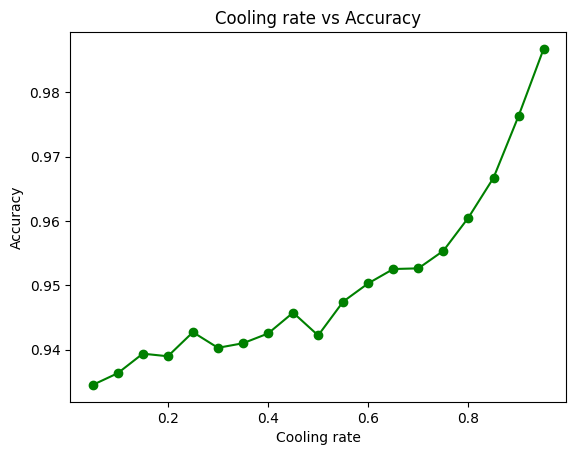

In [13]:
#Cooling rate vs Accuracy

from matplotlib import pyplot as plot

cooling_rates = []
i = 0.05
while i < 1:
    cooling_rates.append(i)
    i += 0.05

results = []

for rate in cooling_rates:
    solutions_sa = []
    for _, row in dataset.iterrows():
        target = row['Best price']
        solution, indexes = simulated_annealing(row, N = 200, initial_temperature=3000, cooling_rate=rate)
        solutions_sa.append(1 if target == solution else 0)
    results.append(np.mean(solutions_sa))

plot.plot(cooling_rates, results, color='green', marker='o', linestyle='solid')
plot.title("Cooling rate vs Accuracy")
plot.xlabel("Cooling rate")
plot.ylabel("Accuracy")
plot.show()

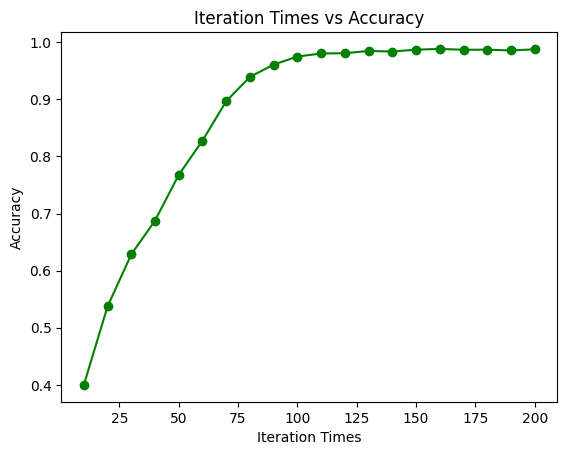

In [107]:
#Iteration Times vs Accuracy

from matplotlib import pyplot as plot

N_list = []
i = 1
while i < 21:
    N_list.append(i*10)
    i += 1

results = []

for n in N_list:
    solutions_sa = []
    for _, row in dataset.iterrows():
        target = row['Best price']
        solution, indexes = simulated_annealing(row, N = n, initial_temperature=3000, cooling_rate=0.95)
        solutions_sa.append(1 if target == solution else 0)
    results.append(np.mean(solutions_sa))

plot.plot(N_list, results, color='green', marker='o', linestyle='solid')
plot.title("Iteration Times vs Accuracy")
plot.xlabel("Iteration Times")
plot.ylabel("Accuracy")
plot.show()

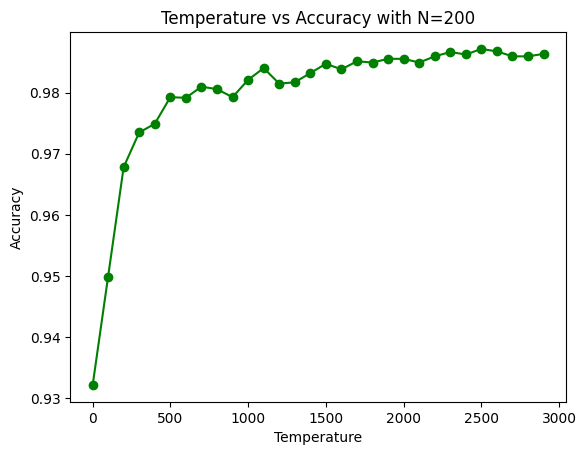

In [106]:
#Temperature vs Accuracy

from matplotlib import pyplot as plot

temperatures = []
i = 1
temperatures.append(1)
while i < 30:
    temperatures.append(i*100)
    i += 1

results2 = []

for temperature in temperatures:
    solutions_sa2 = []
    for _, row in dataset.iterrows():
        target = row['Best price']
        solution2, indexes2 = simulated_annealing(row, N = 200, initial_temperature=temperature, cooling_rate=0.95)
        solutions_sa2.append(1 if target == solution2 else 0)
    results2.append(np.mean(solutions_sa2))

plot.plot(temperatures, results2, color='green', marker='o', linestyle='solid')
plot.title("Temperature vs Accuracy with N=200")
plot.xlabel("Temperature")
plot.ylabel("Accuracy")
plot.show()

------------------------------------------------------------------------------------------------

**7. Genetic Algorithm**

Genetic algorithms are a popular optimization technique inspired by the principles of natural evolution. They explore a wide range of potential solution and operate on a population of solutions simultaneously, allowing parallel exploration of different regions of the solution space. This parallelism not only enable faster search in the solution space, but also helps in avoiding local optima by maintaining a diverse population. When solving the 0-1 knapsack problem, the algorithm can be described in following steps:

1. Initialization
    * The algorithm starts by creating a population of individuals, where each individual represents a possible solution to the knapsack problem.
    * Each individual is represented as a binary string of 0s and 1s, where 1 indicates the corresponding item is included in the knapsack, and 0 indicates it is not.
    
2. Fitness Calculation
    * The fitness of each individual is calculated based on the total price of the items included in the knapsack.
	    * If the total weight of the selected items exceeds the knapsack's capacity, the fitness is set to 0.
    
3. Selection
    * Parents for the next generation are selected using tournament selection.
    * In tournament selection, a subset of individuals is randomly chosen from the population, and the individual with the highest fitness among them is selected as a parent.
	    * This process is repeated to select multiple parents.
    
4. Crossover
    * Parents are used to create offspring through crossover (recombination).
    * A random crossover point is chosen, and the bits beyond that point are exchanged between the parents to create two children.
    
5. Mutation
    * After crossover, each bit in the offspring has a chance to be flipped (mutated) based on the mutation rate.
    * Mutation introduces genetic diversity into the population.
    
6. Replacement
    * The offspring replace the old population, and the process repeats for a fixed number of generations.
    
7. Termination
    * After a specified number of generations, the algorithm terminates.
    * The best individual in the final population represents the best solution to the knapsack problem in the given context.

In [15]:
import random

def calculate_fitness(ind, prices, weights, capacity):
    total_price = 0
    total_weight = 0
    for i in range(len(ind)):
        if ind[i] == 1:
            total_price += prices[i]
            total_weight += weights[i]
    if total_weight > capacity:
        return 0
    else:
        return total_price

def crossover(parent1, parent2, cross_rate):
    if random.random() < cross_rate:
        # Perform one-point crossover
        point = random.randint(1, len(parent1) - 1)
        child1 = parent1[:point] + parent2[point:]
        child2 = parent2[:point] + parent1[point:]
        return child1, child2
    else:
        return parent1, parent2

def mutation(child, mut_rate):
    mutated_child = list(child)
    for i in range(len(mutated_child)):
        if random.random() < mut_rate:
            # Flip the bit (perform mutation)
            mutated_child[i] = 1 - mutated_child[i]
    return tuple(mutated_child)

def tournament_selection(population, fitness_values, tournament_size):
    selected_indices = random.sample(range(len(population)), tournament_size)
    tournament_winner = selected_indices[0]
    for i in selected_indices:
        if fitness_values[i] > fitness_values[tournament_winner]:
            tournament_winner = i
    return population[tournament_winner]

def genetic_algorithm(data, population_size, num_generations, mut_rate, cross_rate, tournament_size):
    weights = data["Weights"]
    prices = data["Prices"]
    capacity = data["Capacity"]
    
    population = []
    for _ in range(population_size):
        individual = tuple(random.randint(0, 1) for _ in range(len(prices)))
        population.append(individual)

    for generation in range(num_generations):
        fitness_values = [calculate_fitness(individual, prices, weights, capacity) for individual in population]

        # Select parents using tournament selection
        parents = [tournament_selection(population, fitness_values, tournament_size) for _ in range(population_size)]

        # Create offspring through crossover and mutation
        offspring = []
        for i in range(0, population_size, 2):
            parent1 = parents[i]
            parent2 = parents[i + 1]
            child1, child2 = crossover(parent1, parent2, cross_rate)
            child1 = mutation(child1, mut_rate)
            child2 = mutation(child2, mut_rate)
            offspring.extend([child1, child2])

        # Replace the old population with the offspring
        population = offspring

    # Find the best solution
    best_solution_price = max(fitness_values)
    best_solution_index = fitness_values.index(best_solution_price)
    best_solution = population[best_solution_index]

    return best_solution_price, best_solution

In [16]:
def genetic_algorithm_worker(parameters):
    mut_rate, cross_rate = parameters
    solutions_ga = []
    for _, row in dataset.iterrows():
        target = row['Best price']
        solution, indexes = genetic_algorithm(row, population_size = 50, num_generations = 50, mut_rate = mut_rate, cross_rate = cross_rate, tournament_size = 5)
        solutions_ga.append(1 if target == solution else 0)
    return np.mean(solutions_ga)

**Default rate**

The rate of crossover is 0.7 and the rate of mutation is 0.1.

In [42]:
print("Genetic Algorithm Accuracy is", genetic_algorithm_worker((0.1, 0.7)))

Genetic Algorithm Accuracy is 0.9984816276951108


**Exploring other rates**

The rate of crossover and mutation both have the range of \[0.1, 0.9\] with step of 0.1.

In [122]:
import multiprocessing
from matplotlib import pyplot as plot

def genetic_algorithm_iteration(mut_rate_range, cross_rate_range):
    pairs = [
        (i, j)
        for i in mut_rate_range
        for j in cross_rate_range
    ]

    with multiprocessing.Pool(processes=None) as pool:
        results = pool.map(genetic_algorithm_worker, pairs)

    return results

def genetic_algorithm_epoch(iteration_count, mut_rate_range, cross_rate_range):
    results = []
    
    for i in range(iteration_count):
        print(f"Iteration {i + 1}: ")
        result = genetic_algorithm_iteration(mut_rate_range, cross_rate_range)
        print(result)
        results.append(result)

    return np.mean(results)

def genetic_algorithm_plot(mut_rate_range, cross_rate_range, data):
    data_transformed = np.reshape(data, (len(mut_rate_range), len(cross_rate_range)))
    plot.imshow(data_transformed, cmap="Greens")

    plot.xticks(np.arange(len(mut_rate_range)), labels=[round(i, 3) for i in mut_rate_range])
    plot.yticks(np.arange(len(cross_rate_range)), labels=[round(i, 3) for i in cross_rate_range])

    plot.xlabel("Mutation rate")
    plot.ylabel("Cross rate")

    plot.colorbar()
    plot.show()

mut_rate_range=np.arange(0.1, 1, 0.1)
cross_rate_range=np.arange(0.1, 1, 0.1)
iteration_count = 5

result = genetic_algorithm_epoch(5, mut_rate_range, cross_rate_range)
genetic_algorithm_plot(mut_rate_range, cross_rate_range, result)

Iteration 1: 


NameError: name 'genetic_algorithm_worker' is not defined

**Your Analysis:**

------------------------------------------------------------------------------------------------

**8. Comparative Study**

The table below shows the average accuracy of algorithms with 10 runs.
Each section above contains its only tables/diagram swith different impact factors. For the generate and test, and greedy algothrim. Since the solutions are always constant, their diagrams are not included into the analysis.

According to the table below, the "Generate and Test" method and Genetic algothrim provide higher accuracies. However, the Generate and Test explores all solutions which needs the highest time cost, so the "Generate and Test" method is not a good choice when the dataset is very large. Simulated Annealing Algorithm is also able to reach a high accuracy that is about 98% after serval test, but the accuracies are not very stable. Sometime the accuracies are about 92%. 

In general, the Genetic Algorithm is the best way among 4 methods.

![Alt text](output.png)

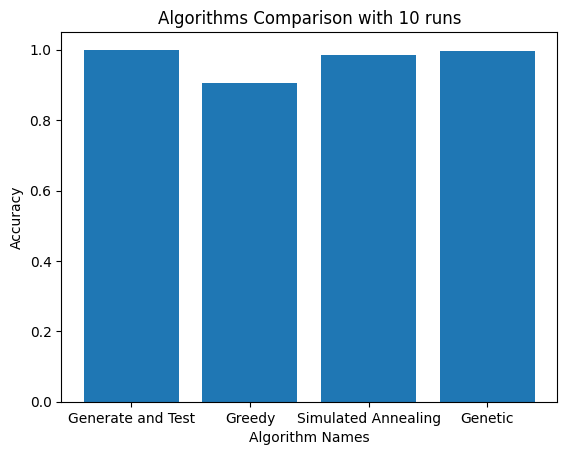

In [38]:
#Algorithms comparison

from matplotlib import pyplot as plot

algorithms = ["Generate and Test", "Greedy", "Simulated Annealing", "Genetic"]
results = [0]*4

tmp_result = 0
for i in range(10):
    solutions = []
    for _, row in dataset.iterrows():
        target = row['Best price']
        solution, indexes = gen_and_test(row)
        solutions.append(1 if target == solution else 0)
    tmp_result += np.mean(solutions)

results[0] = tmp_result/10

tmp_result = 0
for i in range(10):
    solutions_greedy = []
    for _, row in dataset.iterrows():
        target = row['Best price']
        solution, indexes = greedy(row)
        solutions_greedy.append(1 if target == solution else 0)
    tmp_result += np.mean(solutions_greedy)

results[1] = tmp_result/10

tmp_result = 0
for i in range(10):
    solutions_sa = []
    for _, row in dataset.iterrows():
        target = row['Best price']
        solution, indexes = simulated_annealing(row, N = 200, initial_temperature=3000, cooling_rate=0.95)
        solutions_sa.append(1 if target == solution else 0)
    tmp_result += np.mean(solutions_sa)

results[2] = tmp_result/10

tmp_result = 0
for i in range(10):
    solutions_ga = []
    for _, row in dataset.iterrows():
        target = row['Best price']
        solution, indexes = genetic_algorithm(row, population_size = 50, num_generations = 50, mut_rate = 0.1, cross_rate = 0.7, tournament_size = 5)
        solutions_ga.append(1 if target == solution else 0)
    tmp_result += np.mean(solutions_ga)

results[3] = tmp_result/10


plot.xlabel("Algorithm Names")
plot.ylabel("Accuracy")
plot.title("Algorithms Comparison with 10 runs")
plot.bar(algorithms, results)

plot.show()

--------------------------------------------------------------------------


**9. Conclusion**

Comment on the empirical study, its results, and give ideas for future work.

--------------------------------------------------------------------------


**10. References**

[1] NumPy Developers, “NumPy reference,” NumPy reference - NumPy v1.26 Manual, https://numpy.org/doc/1.26/reference/index.html#reference (accessed Oct. 1, 2023).

[2] The Matplotlib development team, “Matplotlib 3.8.0 documentation,” Matplotlib documentation - Matplotlib 3.8.0 documentation, https://matplotlib.org/stable/index.html (accessed Oct. 1, 2023).

[3] Python Software Foundation, “Python 3.11.5 documentation,” 3.11.5 Documentation, https://docs.python.org/3/ (accessed Oct. 1, 2023).

**Hint:** To share a link to your colab notebook, click on "share" on the top right. Then, under *General access* , change *Restricted* to "Anyone with the link".